# Problem Set - Week 5
## Guillermo Trefogli

In [1]:
! pip install sktime
! pip install pmdarima

You should consider upgrading via the 'C:\Users\guill\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\guill\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.all import ForecastingHorizon
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\guill\anaconda3\lib\site-packages\sktime\utils\validation\_dependencies.py:64: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


## 1. EDA

### 1.A 

In [3]:
df_co2 = pd.read_csv('hw5_data_co2.csv', parse_dates = ['ds'])
df_temp = pd.read_csv('hw5_data_temp.csv', parse_dates = ['ds'])

In [4]:
print(df_co2.isnull().sum())
print(df_temp.isnull().sum())

print(df_co2.shape)
print(df_temp.shape)

ds     0
co2    0
dtype: int64
ds      0
temp    0
dtype: int64
(735, 2)
(1674, 2)


In [5]:
from datetime import datetime, timedelta
df_co2['ds'] = df_co2['ds'] - timedelta(days=14)
df = pd.merge(df_co2, df_temp, how = "inner", on = "ds")
df

,ds,co2,temp
0,1958-03-01,315.700,57.38
1,1958-04-01,317.450,57.29
2,1958-05-01,317.510,57.32
3,1958-06-01,316.685,57.02
4,1958-07-01,315.860,57.27
...,...,...,...
730,2019-01-01,410.920,58.29
731,2019-02-01,411.660,58.37
732,2019-03-01,412.000,58.59
733,2019-04-01,413.510,58.50


### 1.B. 
- One dataset provides information for temperature, the other for CO2.
- There are no missing values in the dataset.
- Both variables are similar in terms of time series pattern: increasing trend over time.
- ACF plot shows autocorrelation in time for temperature

In [6]:
df.set_index('ds', inplace = True)
df

,co2,temp
ds,,
1958-03-01,315.700,57.38
1958-04-01,317.450,57.29
1958-05-01,317.510,57.32
1958-06-01,316.685,57.02
1958-07-01,315.860,57.27
...,...,...
2019-01-01,410.920,58.29
2019-02-01,411.660,58.37
2019-03-01,412.000,58.59


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,735.0,354.210673,27.922811,313.20,328.785,351.34,376.515,414.83
temp,735.0,57.603293,0.397159,56.73,57.280,57.59,57.915,58.84


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


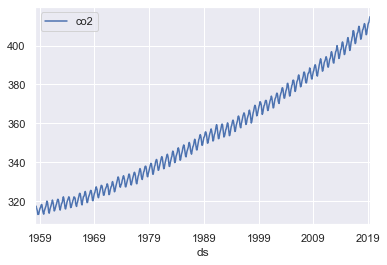

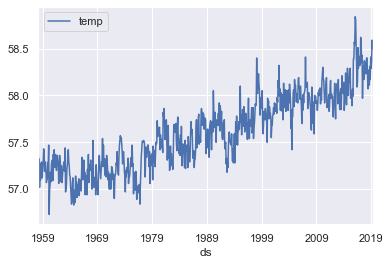

In [8]:
print(df[['co2']].plot())
print(df[['temp']].plot())

In [9]:
df.corr()

,co2,temp
co2,1.000000,0.898635
temp,0.898635,1.000000


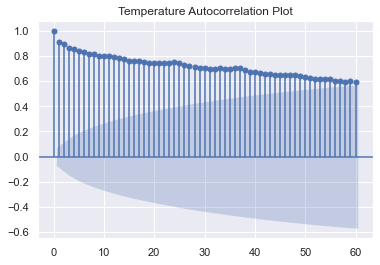

In [10]:
p = plot_acf(df['temp'], lags=60, title='Temperature Autocorrelation Plot')

## Part 2. ARIMA with external regressors

### 2.A. 
- Our variable of interest CO2 initially shows no stationarity:

    - **ADF test** is showing that **non-stationarity can be rejected**. The p-value in the test is lower than 0.05, which means that the null hypothesis of non-stationarity can be rejected.
    - **KPSS test** is showing that **stationarity in the time series can be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series can be rejected.

- Based on ACF and PACF, we can differentiate it to make the time series stational:

    - **ADF test** is showing that **non-stationarity can be rejected**. The p-value in the test is lower than 0.05, which means that the null hypothesis of non-stationarity can be rejected.
    - **KPSS test** is showing that **stationarity in the time series cannot be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series cannot be rejected.

- See below plots and tests outputs.

In [11]:
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

<AxesSubplot:xlabel='ds'>

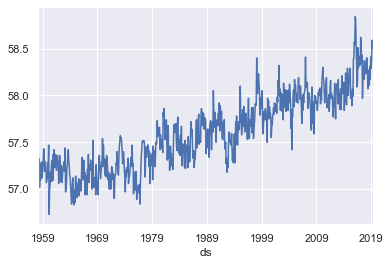

In [12]:
ts_temp = df.groupby(pd.PeriodIndex(df.index, freq="M"))['temp'].mean()
ts_temp.plot()

In [13]:
bctransformer = boxcox.BoxCoxTransformer()
ts_transf = bctransformer.fit_transform(ts_temp)

In [14]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(ts_temp)

In [15]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

def adf_test(timeseries):
    print ('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [16]:
adf_test(df['PCEPI'])

KeyError: 'PCEPI'

In [ ]:
kpss_test(y_train)

### Differenting

In [ ]:
y_train_seasdiff = y_train.diff(12).dropna()

In [ ]:
y_train_seasdiff.plot()
plt.show()

In [ ]:
adf_test(y_train_seasdiff)

In [ ]:
kpss_test(y_train_seasdiff)

In [ ]:
plot_acf(y_train_seasdiff)
plt.show()

In [ ]:
plot_pacf(y_train_seasdiff)
plt.show()

In [ ]:
#y_train_nonseasdiff = np.diff(y_train_seasdiff)
y_train_nonseasdiff = y_train_seasdiff.diff(12).dropna()

In [ ]:
y_train_nonseasdiff.plot()
plt.show()

In [ ]:
adf_test(y_train_nonseasdiff)

In [ ]:
kpss_test(y_train_nonseasdiff)

In [ ]:
plot_acf(y_train_nonseasdiff, lags = 40)
plt.show()

In [ ]:
plot_pacf(y_train_nonseasdiff, lags = 40)
plt.show()

### 2.B. 

### ARIMA model:

In [ ]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(3,1,1), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

In [ ]:
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))

In [ ]:
residuals = sarima_fit.resid
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [ ]:
residuals

In [ ]:
resid = residuals[24:]
resid

In [ ]:
resid.plot()

In [ ]:
resid.hist()

In [ ]:
plot_acf(resid, lags = 40)
plt.show()

In [ ]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

### AUTOarima model:

In [ ]:
from sktime.forecasting.arima import AutoARIMA
from pmdarima.arima import auto_arima

In [ ]:
y_train, y_test = temporal_train_test_split(ts_temp)

In [ ]:
y_train.index.min(), y_train.index.max()

In [ ]:
y_test.index.min(), y_test.index.max()

In [ ]:
auto_arima = auto_arima(y_train, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(auto_arima.aic())

In [ ]:
print(auto_arima.summary())

In [ ]:
print(auto_arima.plot_diagnostics(figsize=(12,8)))

In [ ]:
res = auto_arima.resid()
residuals = pd.DataFrame(res,columns=["Residuals"])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
resid = residuals[24:]
resid

In [ ]:
resid.plot()

In [ ]:
resid.hist()

In [ ]:
plot_acf(resid, lags = 80)
plt.show()

In [ ]:
plot_pacf(resid, lags = 80)
plt.show()

In [ ]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

### 2.C. 

In [ ]:
y_pred = pd.DataFrame(auto_arima.predict(n_periods = len(y_test)), index = y_test.index)
y_pred.columns = ['pred']
y_pred

In [ ]:
y_pred = y_pred.groupby(pd.PeriodIndex(y_pred.index, freq="M"))['pred'].mean()
y_pred.plot()

In [ ]:
def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot()
    y_test.plot()

    y_pred.plot()

    plt.legend(['y_train','y_test','y_pred'])
    plt.show()

In [ ]:
plot_results(y_train, y_test, y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test, y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

### 2.D. 

In [ ]:
ts = df.groupby(pd.PeriodIndex(df.index, freq="M"))['temp', 'co2'].mean()
ts.plot()

In [ ]:
y_train, y_test = temporal_train_test_split(ts)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(endog=y_train['temp'],
                        exog = y_train['co2'],
                        order=(3,1,1),
                        trend='c',
                        seasonal_order=(2, 1, 0, 12))
sarimax_fit = sarimax_model.fit()
print(sarimax_fit.summary())

In [ ]:
print("AICc for order " + str(sarimax_model.order) + str(sarimax_model.seasonal_order) +": " +str(sarimax_fit.aicc))

In [ ]:
# residual checks
# line plot of residuals
residuals = sarimax_fit.resid
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
residuals

In [ ]:
resid = residuals[24:]
resid

In [ ]:
resid.plot()

In [ ]:
resid.hist()

In [ ]:
plot_acf(resid, lags = 40)
plt.show()

In [ ]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

### 2.E. 

In [ ]:
y_pred = sarimax_fit.forecast(steps = len(y_test['temp']),  exog=y_test['co2'])

In [ ]:
y_train

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test['temp'], y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test['temp'], y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test['temp'], y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test['temp'], y_pred)

In [ ]:
sarimax_fit.summary()

## Part 3. Prophet with additional regressors

### 3.A. 

In [ ]:
! pip install pystan --user
! pip install fbprophet --user

In [ ]:
! pip install wbdata

In [ ]:
from util_prophet import *
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

In [ ]:
y_train_prophet = y_train
y_train_prophet['ds'] = y_train_prophet.index
y_train_prophet.rename(columns={'temp':'y'}, inplace=True)

y_test_prophet = y_test
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.rename(columns={'temp':'y'}, inplace=True)

In [ ]:
y_train_prophet

In [ ]:
y_train_prophet['ds'] = y_train_prophet['ds'].dt.strftime('%Y-%m').add('-01 00:00:00.000')
print(y_train_prophet)

In [ ]:
model = Prophet()
model.fit(y_train_prophet)

In [ ]:
future_data = model.make_future_dataframe(periods=len(y_test), freq='m')

In [ ]:
forecast_data = model.predict(future_data)
forecast_data.iloc[0:3].T

In [ ]:
p = model.plot(forecast_data)

In [ ]:
forecast_data

In [ ]:
forecast_data['ds'] == y_test.index[0]

In [ ]:
ind = forecast_data[forecast_data['ds'] == y_test.index[0]].index[0]
y_pred = forecast_data[ind:]['yhat']
y_true = y_test['y']

In [ ]:
mae =  mean_absolute_error(y_pred, y_true)
mse = mean_squared_error(y_pred, y_true)
mape = mean_absolute_percentage_error(y_pred, y_true)
smape = smape(np.array(y_pred), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred, y_true, y_train=y_train['y'])

print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

### 3.B. 10 pts Adjust seasonality, changepoint priors or other methods to see if you can create a better fit model. Examine the residuals. Using the predicted values and y train, calculate the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [ ]:
model_seasonal = Prophet(seasonality_prior_scale=10, changepoint_prior_scale=5)
model_seasonal.fit(y_train_prophet)
future_data_s = model_seasonal.make_future_dataframe(periods=len(y_test), freq='m')
forecast_data_s = model_seasonal.predict(future_data_s)
forecast_data_s.iloc[0:3].T

In [ ]:
p_s = model_seasonal.plot(forecast_data_s)

In [ ]:
ind_s = forecast_data_s[forecast_data_s['ds'] == y_test.index[0]].index[0]
y_pred_s = forecast_data_s[ind:]['yhat']

In [ ]:
mae =  mean_absolute_error(y_pred_s, y_true)
mse = mean_squared_error(y_pred_s, y_true)
mape = mean_absolute_percentage_error(y_pred_s, y_true)
#smape = smape(np.array(y_pred_s), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred_s, y_true, y_train=y_train['y'])

print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
#print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

### 3.C. 10 pts Using your best prophet model, include co2 as an external regressor. Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [ ]:
y_train_prophet

In [ ]:
y_test_prophet

In [ ]:
def co2(ds):
    date = (pd.to_datetime(ds)).date()
    
    if y_train_prohet[date:].empty:
        return y_test_prohet[date:]['co2'].values[0]
    else:
        return (y_train_prophet[date:]['co2']).values[0]
    
    return 0

In [ ]:
mr = Prophet(seasonality_prior_scale=10, changepoint_prior_scale=5)
mr.add_regressor('co2')
mr.fit(y_train_prophet)
future_r = mr.make_future_dataframe(periods=len(y_test_prophet), freq='m')
future_r['co2'] = future_r['ds'].apply(co2)
forecast_r = mr.predict(future_r)

In [ ]:
forecast_r

In [ ]:
ind_r = forecast_r[forecast_r['ds'] == y_test_prophet.index[0]].index[0]
y_pred_r = forecast_r[ind:]['yhat']

mae =  mean_absolute_error(y_pred_r, y_true)
mse = mean_squared_error(y_pred_r, y_true)
mape = mean_absolute_percentage_error(y_pred_r, y_true)
#smape = smape(np.array(y_pred_s), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred_r, y_true, y_train=y_train['y'])

print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
#print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

### 3.D. 5 pts Give a summary of your modeling in prophet. What improved the model, what made the fit worse. Give your reasonings why this would happen given the patterns in the data.

## Part 4. 10 pts – conclusion

### 4.A. 5 pts Which was the best model according to your error metrics?

According to performance metrics (MAE, MSE, MAPE, sMAPE, MASE), Prophet model is the one with a better predictive power.

### 4.B. 5 pts If you had this data for 100 locations (different pairs of time series), how would you approach modeling this data?